In [1]:
from utils import FundamentalData, delta, rank, alpha_example_1, alpha_example_2, alpha_example_4, alpha_example_3, alpha_example_5, FinancialDataProcessor
from threeDF import process_data


In [2]:
def fetch_data():
    while True:
        user_input = input("To fetch data enter 1 else 0: ")
        if user_input == '1':
            process_data()
            break
        elif user_input == '0':
            print("Data fetch aborted.")
            break
        else:
            print("Invalid input. Please enter 1 or 0.")
fetch_data()

Data fetch aborted.


In [5]:
def alpha_example_6(fundamental_data):
    return {
        # 'alpha':"rank(fundamental_data.npm)",
        'alpha':"rank(fundamental_data.npm) + rank(fundamental_data.dte)",
        # 'alpha': "ts_rank(fundamental_data.npm, 15)",
        # 'alpha' : "adx(fundamental_data.data, 15)",

        # 'alpha' : "rank(fundamental_data.peRatio) / ema(fundamental_data.peRatio, 20)",
        'neutralisation': 'market',
        'decay': 5,
    }


/Users/khushnarang/Desktop/HFT/LFT/IFT/utils.py:343: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.weight_matrix[i, j] = alpha_values.loc[self.dates['date'][i], self.stocks['Symbol'][j]]
/Users/khushnarang/Desktop/HFT/LFT/IFT/utils.py:347: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.weight_matrix[i, j] = ((val1)*(decay_x-1) + val2) / decay_x


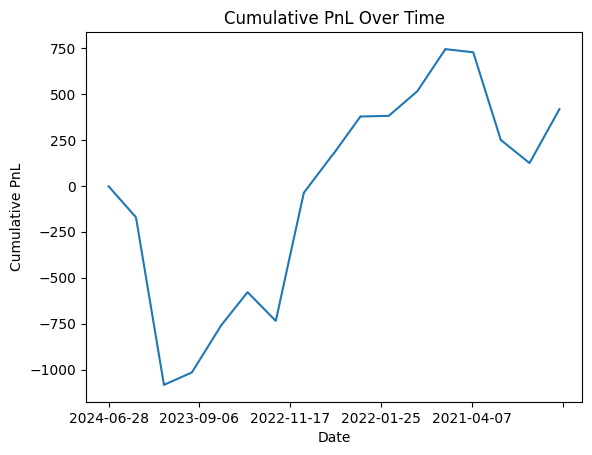

{'std_dev_daily_pnl': np.float64(0.38886628381883015),
 'sharpe_ratio': np.float64(0.2976648814972342),
 'max_drawdown': np.float64(3.5966700563901215e+18),
 'average_daily_return': array([-1.0327518 ,  0.49812179,  0.78511987, -0.0951317 ,  0.26460842]),
 'average_turnover': np.float64(0.16948845942889415)}

In [6]:
processor = FinancialDataProcessor('date.csv', 'ind_nifty500list.csv', 'my_3d_dataarray.nc', 'sectorData.csv', alpha_example_6)
sector = input("Enter the sector['Financial Services' 'Industrials' 'Basic Materials'....etc, for all of them enter 'All' : ") 
processor.calculate_weights(sector)
processor.calculate_pnl(sector)
processor.plot_cumulative_pnl(sector)
processor.calculate_pnl_quality()